In [88]:
import tensorflow as tf
tf.__version__
tf.config.experimental.enable_op_determinism()
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
  tf.config.experimental.set_memory_growth(gpu, True)

In [89]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
import matplotlib.pyplot as plt
import random

In [90]:
def plot_columns(df):
    colors = plt.cm.tab20(range(df.shape[1]))  

    for i, column in enumerate(df.columns):
        color = colors[i % 24]

        plt.figure()
        plt.plot(df.index, df[column], color=color)
        plt.xlabel('Tempo')
        plt.ylabel('Valor')
        plt.title(column)

    plt.show()

In [91]:
def plot_correlation_matrix(df):
    correlation_matrix = df.corr()
    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
    plt.title("Correlation Matrix Heatmap")
    plt.show()

In [92]:
tf.keras.backend.clear_session()

In [93]:
subject = 'Minas Gerais - Consumo de Cimento (t)'
start_index = 0
split_index = 203
window_size = 36
train_split = split_index + 1 - 12

In [94]:
data = pd.read_csv('2003_mo_model_input_MG.csv')
pd.set_option('display.max_columns', None)
data

,Unnamed: 0,Minas Gerais- custo m2 (R$),Minas Gerais - IDH,Minas Gerais - Consumo de Cimento (t),Minas Gerais - Depósito Poupança (R$),Minas Gerais - IDH Educacao,Minas Gerais - value,Minas Gerais - IDH Renda,Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),Minas Gerais - Produção de Cimento (t),Minas Gerais - Desemprego,Minas Gerais - PIB - Estadual,Minas Gerais - PIB - Construção Civil,Minas Gerais - PIB - Per Capita,Minas Gerais - PIB - Preços de Mercado,Operações de crédito - saldo da carteira de crédito (R$),Estoque liquido de capital fixo - (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),População,PPC (US$),Taxa Selic (%),Minas Gerais - IDH Longevidade
0,2003-1,10943.259600,0.756537,247.134,2.263741e+07,0.698929,0.334536,0.759345,1.881651,889.396645,1304.196449,18.796583,16.168039,85.634952,0.300000,648.891160,8.242462,2.937752e+08,1.725077e+07,14.096054,2.759117e+08,384683.093871,7.330309e+06,231.510748,2.097001e+06,1.036534,3.656420,0.969649,0.724032,-5331.049150,11.520143,126.459809,1.772069e+08,169.247665,1.611498,0.826175
1,2003-2,11044.202677,0.756708,305.708,2.272827e+07,0.699250,0.335670,0.759119,1.872777,889.450610,1289.394416,18.293640,15.115445,83.129710,0.300000,652.396314,8.236470,2.941480e+08,1.726959e+07,14.102603,2.760648e+08,385266.203928,7.335910e+06,208.710157,2.000523e+06,0.993449,3.654697,0.950783,0.690297,-5318.079644,11.189862,126.581813,1.773884e+08,170.176810,1.450389,0.826617
2,2003-3,11138.440825,0.756879,284.168,2.281913e+07,0.699571,0.336553,0.758894,1.638997,889.584406,1285.306737,18.099369,14.148246,79.655520,0.300000,655.911573,8.230479,2.945208e+08,1.728841e+07,14.109152,2.762178e+08,385305.059560,7.341511e+06,227.704841,1.963278e+06,0.973020,3.654266,0.938332,0.669681,-5436.417870,10.820792,126.703818,1.775699e+08,171.135713,1.870184,0.827060
3,2003-4,11231.690825,0.757050,286.594,2.290999e+07,0.699892,0.336531,0.758669,1.339260,890.048010,1258.400433,17.617245,13.127518,77.295209,0.380914,656.746430,8.224488,2.948935e+08,1.730723e+07,14.115701,2.763709e+08,385752.052697,7.347112e+06,278.121073,1.954187e+06,0.940489,3.653595,0.926401,0.660494,-5707.015274,10.417840,126.825822,1.777514e+08,172.116904,1.355287,0.827502
4,2003-5,11322.829101,0.757222,312.455,2.300085e+07,0.700213,0.336406,0.758443,1.204123,890.232394,1261.365893,17.005052,12.074203,74.991327,0.574731,660.114672,8.218497,2.952663e+08,1.732605e+07,14.122250,2.765239e+08,387164.022451,7.352713e+06,344.827633,1.975493e+06,0.917493,3.650266,0.951683,0.648337,-5599.317941,9.959690,126.976217,1.779329e+08,173.072271,1.585538,0.827945
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
244,2023-5,38004.550289,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
245,2023-6,37962.793190,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
246,2023-7,37913.793566,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
247,2023-8,37853.865772,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


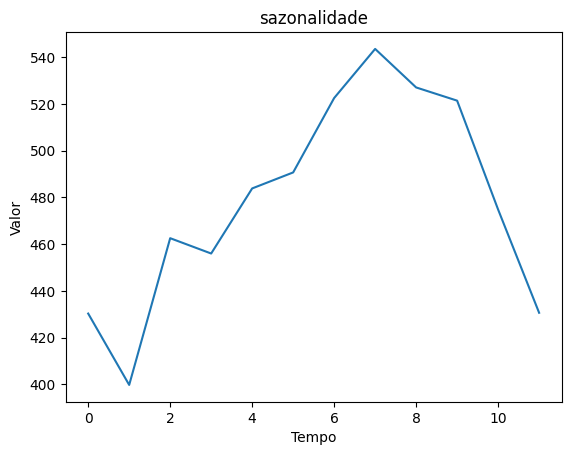

,sazonalidade
sazonalidade,
0,430.291893
1,399.739181
2,462.562790
3,455.999112
4,483.868403
5,490.717485
6,522.571480
7,543.599374
8,527.106799


In [95]:
def calculate_monthly_means(consume_of_cement, subject):
    df = pd.DataFrame({subject: consume_of_cement[:train_split]})
    df['sazonalidade'] = df.index % 12
    monthly_means = df.groupby('sazonalidade')[subject].mean()
    result_df = pd.DataFrame({'sazonalidade': monthly_means})

    return result_df

media_df = calculate_monthly_means(data[subject], subject)
plot_columns(media_df)
media_df

In [96]:
def fill_original_df_with_monthly_means(df_og, media_df):
    monthly_means = media_df['sazonalidade'].tolist()
    df_og['sazonalidade'] = [monthly_means[i % 12] for i in range(len(df_og))]
    return df_og

data = fill_original_df_with_monthly_means(data, media_df)
data = data[[col for col in data.columns if col != subject] + [subject]] #Seta consumo (target) para a coluna final
data

,Unnamed: 0,Minas Gerais- custo m2 (R$),Minas Gerais - IDH,Minas Gerais - Depósito Poupança (R$),Minas Gerais - IDH Educacao,Minas Gerais - value,Minas Gerais - IDH Renda,Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),Minas Gerais - Produção de Cimento (t),Minas Gerais - Desemprego,Minas Gerais - PIB - Estadual,Minas Gerais - PIB - Construção Civil,Minas Gerais - PIB - Per Capita,Minas Gerais - PIB - Preços de Mercado,Operações de crédito - saldo da carteira de crédito (R$),Estoque liquido de capital fixo - (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),População,PPC (US$),Taxa Selic (%),Minas Gerais - IDH Longevidade,sazonalidade,Minas Gerais - Consumo de Cimento (t)
0,2003-1,10943.259600,0.756537,2.263741e+07,0.698929,0.334536,0.759345,1.881651,889.396645,1304.196449,18.796583,16.168039,85.634952,0.300000,648.891160,8.242462,2.937752e+08,1.725077e+07,14.096054,2.759117e+08,384683.093871,7.330309e+06,231.510748,2.097001e+06,1.036534,3.656420,0.969649,0.724032,-5331.049150,11.520143,126.459809,1.772069e+08,169.247665,1.611498,0.826175,430.291893,247.134
1,2003-2,11044.202677,0.756708,2.272827e+07,0.699250,0.335670,0.759119,1.872777,889.450610,1289.394416,18.293640,15.115445,83.129710,0.300000,652.396314,8.236470,2.941480e+08,1.726959e+07,14.102603,2.760648e+08,385266.203928,7.335910e+06,208.710157,2.000523e+06,0.993449,3.654697,0.950783,0.690297,-5318.079644,11.189862,126.581813,1.773884e+08,170.176810,1.450389,0.826617,399.739181,305.708
2,2003-3,11138.440825,0.756879,2.281913e+07,0.699571,0.336553,0.758894,1.638997,889.584406,1285.306737,18.099369,14.148246,79.655520,0.300000,655.911573,8.230479,2.945208e+08,1.728841e+07,14.109152,2.762178e+08,385305.059560,7.341511e+06,227.704841,1.963278e+06,0.973020,3.654266,0.938332,0.669681,-5436.417870,10.820792,126.703818,1.775699e+08,171.135713,1.870184,0.827060,462.562790,284.168
3,2003-4,11231.690825,0.757050,2.290999e+07,0.699892,0.336531,0.758669,1.339260,890.048010,1258.400433,17.617245,13.127518,77.295209,0.380914,656.746430,8.224488,2.948935e+08,1.730723e+07,14.115701,2.763709e+08,385752.052697,7.347112e+06,278.121073,1.954187e+06,0.940489,3.653595,0.926401,0.660494,-5707.015274,10.417840,126.825822,1.777514e+08,172.116904,1.355287,0.827502,455.999112,286.594
4,2003-5,11322.829101,0.757222,2.300085e+07,0.700213,0.336406,0.758443,1.204123,890.232394,1261.365893,17.005052,12.074203,74.991327,0.574731,660.114672,8.218497,2.952663e+08,1.732605e+07,14.122250,2.765239e+08,387164.022451,7.352713e+06,344.827633,1.975493e+06,0.917493,3.650266,0.951683,0.648337,-5599.317941,9.959690,126.976217,1.779329e+08,173.072271,1.585538,0.827945,483.868403,312.455
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
244,2023-5,38004.550289,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,483.868403,NaN
245,2023-6,37962.793190,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,490.717485,NaN
246,2023-7,37913.793566,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,522.571480,NaN
247,2023-8,37853.865772,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,543.599374,NaN


In [97]:
# Shift para prever futuro e não presente
target_data = data[subject].shift(-24)
target_data

0      268.591
1      246.372
2      292.439
3      310.034
4      322.741
        ...   
244        NaN
245        NaN
246        NaN
247        NaN
248        NaN
Name: Minas Gerais - Consumo de Cimento (t), Length: 249, dtype: float64

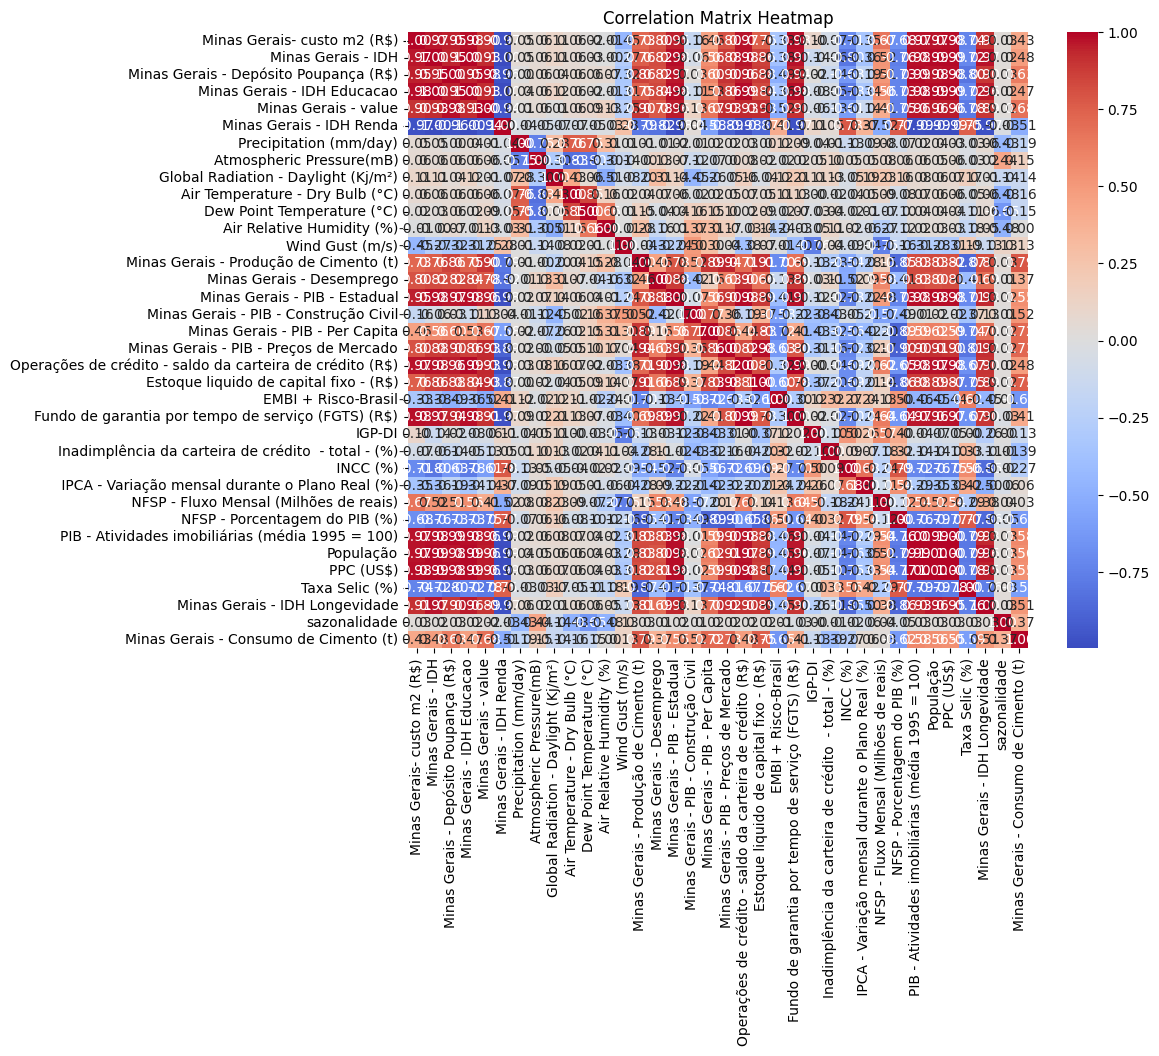

In [98]:
plot_data = data.iloc[:split_index + 1,1:]
plot_correlation_matrix(plot_data)

In [99]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

safe_data = data.iloc[:split_index + 1,1:-1]

def calculate_vif(dataframe):
    vif_data = pd.DataFrame()
    vif_data["Feature"] = dataframe.columns
    vif_data["VIF"] = [variance_inflation_factor(dataframe.values, i) for i in range(dataframe.shape[1])]
    return vif_data

def remove_high_vif_columns(dataframe, threshold=1000):
    i=0
    while True:
        vif_result = calculate_vif(dataframe)
        high_vif_column = vif_result.loc[vif_result["VIF"].idxmax()]["Feature"]
        
        if vif_result["VIF"].max() <= threshold:
            print(f"Num columns removed: {i}")
            return dataframe
        i += 1
        dataframe = dataframe.drop(high_vif_column, axis=1)

In [100]:
safe_data = data.iloc[:split_index + 1,1:-1]
vif_info = calculate_vif(safe_data)
vif_info

,Feature,VIF
0,Minas Gerais- custo m2 (R$),8.533154e+05
1,Minas Gerais - IDH,1.617481e+09
2,Minas Gerais - Depósito Poupança (R$),6.045835e+04
3,Minas Gerais - IDH Educacao,6.413072e+05
4,Minas Gerais - value,1.301266e+05
5,Minas Gerais - IDH Renda,9.421755e+07
6,Precipitation (mm/day),9.268416e+01
7,Atmospheric Pressure(mB),1.172391e+07
8,Global Radiation - Daylight (Kj/m²),2.854697e+03
9,Air Temperature - Dry Bulb (°C),3.876735e+05


In [101]:
data =data.drop(['Air Temperature - Dry Bulb (°C)',
                 'Precipitation (mm/day)',
                 'Global Radiation - Daylight (Kj/m²)', 
                 'Air Relative Humidity (%)'], axis=1)
data = remove_high_vif_columns(safe_data, 10000000)
data

Num columns removed: 6


,Minas Gerais- custo m2 (R$),Minas Gerais - Depósito Poupança (R$),Minas Gerais - value,Minas Gerais - IDH Renda,Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),Minas Gerais - Produção de Cimento (t),Minas Gerais - Desemprego,Minas Gerais - PIB - Estadual,Minas Gerais - PIB - Construção Civil,Operações de crédito - saldo da carteira de crédito (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),PPC (US$),Taxa Selic (%),Minas Gerais - IDH Longevidade,sazonalidade
0,10943.259600,2.263741e+07,0.334536,0.759345,1.881651,889.396645,1304.196449,18.796583,16.168039,85.634952,0.300000,648.891160,8.242462,2.937752e+08,1.725077e+07,3.846831e+05,231.510748,2.097001e+06,1.036534,3.656420,0.969649,0.724032,-5331.049150,11.520143,126.459809,169.247665,1.611498,0.826175,430.291893
1,11044.202677,2.272827e+07,0.335670,0.759119,1.872777,889.450610,1289.394416,18.293640,15.115445,83.129710,0.300000,652.396314,8.236470,2.941480e+08,1.726959e+07,3.852662e+05,208.710157,2.000523e+06,0.993449,3.654697,0.950783,0.690297,-5318.079644,11.189862,126.581813,170.176810,1.450389,0.826617,399.739181
2,11138.440825,2.281913e+07,0.336553,0.758894,1.638997,889.584406,1285.306737,18.099369,14.148246,79.655520,0.300000,655.911573,8.230479,2.945208e+08,1.728841e+07,3.853051e+05,227.704841,1.963278e+06,0.973020,3.654266,0.938332,0.669681,-5436.417870,10.820792,126.703818,171.135713,1.870184,0.827060,462.562790
3,11231.690825,2.290999e+07,0.336531,0.758669,1.339260,890.048010,1258.400433,17.617245,13.127518,77.295209,0.380914,656.746430,8.224488,2.948935e+08,1.730723e+07,3.857521e+05,278.121073,1.954187e+06,0.940489,3.653595,0.926401,0.660494,-5707.015274,10.417840,126.825822,172.116904,1.355287,0.827502,455.999112
4,11322.829101,2.300085e+07,0.336406,0.758443,1.204123,890.232394,1261.365893,17.005052,12.074203,74.991327,0.574731,660.114672,8.218497,2.952663e+08,1.732605e+07,3.871640e+05,344.827633,1.975493e+06,0.917493,3.650266,0.951683,0.648337,-5599.317941,9.959690,126.976217,173.072271,1.585538,0.827945,483.868403
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199,28622.079387,5.394061e+07,0.540458,0.729989,1.402776,889.941858,1202.960854,18.160786,12.938007,74.832466,0.054442,1202.186369,9.462616,3.435942e+08,1.774901e+07,3.339533e+06,256.861070,1.038665e+07,1.139835,3.035443,0.628071,0.411247,6518.883661,1.836884,207.092470,437.906135,0.516394,0.857278,543.599374
200,28888.021415,5.451890e+07,0.544043,0.729968,1.687258,889.004548,1228.571482,18.855723,13.755409,75.599591,0.036987,1200.275536,9.451521,3.432648e+08,1.775222e+07,3.365687e+06,257.536049,1.036684e+07,1.152658,3.032326,0.635009,0.433581,6534.198970,1.814025,207.285636,438.554287,0.509923,0.857093,527.106799
201,29157.817719,5.509719e+07,0.547699,0.729946,1.853922,888.141858,1219.235340,19.294391,14.677543,77.529116,0.057108,1204.078153,9.440425,3.429355e+08,1.775542e+07,3.396904e+06,259.995111,1.094126e+07,1.188899,3.007554,0.648424,0.461431,6135.626515,1.810325,207.478801,439.156241,0.467083,0.856908,521.455091
202,29432.688797,5.567549e+07,0.551425,0.729924,1.955526,887.731880,1176.283595,19.597377,15.412638,79.433800,0.072861,1204.753939,9.429329,3.426061e+08,1.775863e+07,3.425371e+06,262.843441,1.165215e+07,1.180399,2.995976,0.663946,0.480964,6503.475785,1.810689,207.781676,439.704663,0.441494,0.856723,474.829188


In [102]:
input_data = data.iloc[:split_index + 1,1:-1]
mean = np.mean(input_data, axis=0)
stddev =  np.std(input_data, axis=0)
input_data = ((input_data - mean) /stddev)
# scaler=MinMaxScaler()
# scaled_data = scaler.fit_transform(input_data)
# input_data = pd.DataFrame(scaled_data, columns=input_data.columns)
input_data

,Minas Gerais - Depósito Poupança (R$),Minas Gerais - value,Minas Gerais - IDH Renda,Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),Minas Gerais - Produção de Cimento (t),Minas Gerais - Desemprego,Minas Gerais - PIB - Estadual,Minas Gerais - PIB - Construção Civil,Operações de crédito - saldo da carteira de crédito (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),PPC (US$),Taxa Selic (%),Minas Gerais - IDH Longevidade
0,-1.674604,-1.575817,1.968268,0.571844,0.397535,0.722920,0.166665,1.497005,2.528702,-2.859788,-2.202855,-0.752424,-1.806910,-1.971018,-1.405679,-0.581961,-1.384242,2.574314,1.320402,3.184489,2.782450,0.097384,4.506880,-1.894583,-1.851489,2.125141,-2.516125
1,-1.665224,-1.560482,1.943611,0.550242,0.447040,0.553764,-0.302551,0.733263,1.757730,-2.859788,-2.182122,-0.759292,-1.786501,-1.919572,-1.405133,-0.804750,-1.415865,2.334870,1.314693,3.029073,2.407943,0.100462,4.328460,-1.889555,-1.840236,1.610904,-2.468087
2,-1.655844,-1.548550,1.918953,-0.018847,0.569778,0.507051,-0.483794,0.031483,0.688571,-2.859788,-2.161328,-0.766160,-1.766091,-1.868126,-1.405096,-0.619149,-1.428073,2.221334,1.313266,2.926505,2.179073,0.072380,4.129086,-1.884527,-1.828623,2.950828,-2.420048
3,-1.646464,-1.548848,1.894296,-0.748494,0.995065,0.199569,-0.933586,-0.709137,-0.037799,-2.733213,-2.156390,-0.773028,-1.745682,-1.816680,-1.404678,-0.126522,-1.431053,2.040542,1.311046,2.828220,2.077086,0.008167,3.911409,-1.879499,-1.816740,1.307354,-2.372010
4,-1.637084,-1.550544,1.869638,-1.077457,1.164210,0.233458,-1.504726,-1.473401,-0.746804,-2.430022,-2.136466,-0.779896,-1.725272,-1.765234,-1.403356,0.525280,-1.424070,1.912744,1.300019,3.036493,1.942128,0.033724,3.663912,-1.873302,-1.805169,2.042281,-2.323972
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199,1.556972,1.208028,-1.244203,-0.593879,0.897687,-0.433987,-0.426495,-0.846642,-0.795692,-3.243919,1.070020,0.646276,0.920674,-0.608959,1.360064,-0.334258,1.332879,3.148408,-0.736097,0.370628,-0.689886,2.909383,-0.724085,1.428371,1.402207,-1.370268,0.860343
200,1.616672,1.256499,-1.246573,0.098633,0.037845,-0.141312,0.221839,-0.253551,-0.559615,-3.271224,1.058717,0.633557,0.902641,-0.600196,1.384545,-0.327663,1.326386,3.219670,-0.746418,0.427775,-0.441954,2.913017,-0.736434,1.436331,1.410056,-1.390925,0.840255
201,1.676371,1.305916,-1.248943,0.504343,-0.753544,-0.248004,0.631090,0.415531,0.034184,-3.239748,1.081210,0.620837,0.884609,-0.591433,1.413764,-0.303635,1.514665,3.421082,-0.828457,0.538287,-0.132782,2.818435,-0.738433,1.444292,1.417346,-1.527663,0.820166
202,1.736071,1.356297,-1.251314,0.751677,-1.129637,-0.738851,0.913758,0.948901,0.620338,-3.215106,1.085207,0.608118,0.866576,-0.582670,1.440408,-0.275803,1.747673,3.373840,-0.866800,0.666156,0.084061,2.905726,-0.738236,1.456774,1.423988,-1.609340,0.800078


In [103]:
# input para treinamento
train_input = input_data.iloc[start_index:train_split]
train_input

,Minas Gerais - Depósito Poupança (R$),Minas Gerais - value,Minas Gerais - IDH Renda,Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),Minas Gerais - Produção de Cimento (t),Minas Gerais - Desemprego,Minas Gerais - PIB - Estadual,Minas Gerais - PIB - Construção Civil,Operações de crédito - saldo da carteira de crédito (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),PPC (US$),Taxa Selic (%),Minas Gerais - IDH Longevidade
0,-1.674604,-1.575817,1.968268,0.571844,0.397535,0.722920,0.166665,1.497005,2.528702,-2.859788,-2.202855,-0.752424,-1.806910,-1.971018,-1.405679,-0.581961,-1.384242,2.574314,1.320402,3.184489,2.782450,0.097384,4.506880,-1.894583,-1.851489,2.125141,-2.516125
1,-1.665224,-1.560482,1.943611,0.550242,0.447040,0.553764,-0.302551,0.733263,1.757730,-2.859788,-2.182122,-0.759292,-1.786501,-1.919572,-1.405133,-0.804750,-1.415865,2.334870,1.314693,3.029073,2.407943,0.100462,4.328460,-1.889555,-1.840236,1.610904,-2.468087
2,-1.655844,-1.548550,1.918953,-0.018847,0.569778,0.507051,-0.483794,0.031483,0.688571,-2.859788,-2.161328,-0.766160,-1.766091,-1.868126,-1.405096,-0.619149,-1.428073,2.221334,1.313266,2.926505,2.179073,0.072380,4.129086,-1.884527,-1.828623,2.950828,-2.420048
3,-1.646464,-1.548848,1.894296,-0.748494,0.995065,0.199569,-0.933586,-0.709137,-0.037799,-2.733213,-2.156390,-0.773028,-1.745682,-1.816680,-1.404678,-0.126522,-1.431053,2.040542,1.311046,2.828220,2.077086,0.008167,3.911409,-1.879499,-1.816740,1.307354,-2.372010
4,-1.637084,-1.550544,1.869638,-1.077457,1.164210,0.233458,-1.504726,-1.473401,-0.746804,-2.430022,-2.136466,-0.779896,-1.725272,-1.765234,-1.403356,0.525280,-1.424070,1.912744,1.300019,3.036493,1.942128,0.033724,3.663912,-1.873302,-1.805169,2.042281,-2.323972
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
187,1.068049,0.791886,-1.224348,0.971432,0.250837,-0.811119,-0.898472,-0.542923,0.249102,-0.231675,0.707853,0.760991,1.091537,-0.747842,1.193119,-0.234432,1.098595,0.237913,-0.637894,-1.790206,-1.972576,2.018327,-0.537386,1.267871,1.279826,-1.152820,1.077953
188,1.082254,0.807197,-1.225001,1.225127,-0.404499,-0.302191,-0.256111,-0.003219,0.320071,-0.255339,0.739533,0.755855,1.082610,-0.732333,1.206925,-0.187714,1.076314,0.559735,-0.723145,-1.629944,-1.832285,2.313396,-0.553461,1.288480,1.291262,-1.253503,1.062555
189,1.096459,0.822867,-1.225653,1.707449,-0.515308,0.385446,0.485260,0.508765,0.218633,-0.503971,0.777326,0.750719,1.073683,-0.716825,1.227934,-0.161779,1.263463,0.802696,-0.863773,-1.383366,-1.767518,2.353157,-0.577640,1.309088,1.301919,-1.425444,1.047156
190,1.110664,0.836075,-1.226306,1.788482,-0.720407,0.869177,1.043194,0.862958,0.099712,-0.992399,0.817040,0.745582,1.064756,-0.701316,1.246115,-0.157728,1.498990,1.106124,-0.975183,-1.227161,-1.688436,2.550824,-0.606406,1.322965,1.311660,-1.237935,1.031757


In [104]:
# Alvo para treinamento
train_target = target_data.iloc[start_index:train_split]
train_target

0      268.591
1      246.372
2      292.439
3      310.034
4      322.741
        ...   
187    715.882
188    686.640
189    645.975
190    552.352
191    502.591
Name: Minas Gerais - Consumo de Cimento (t), Length: 192, dtype: float64

In [105]:
def create_batches(t_input, t_target, window_size, start_from):
    
    X_batches = []
    y_batches = []

    train_input_values = t_input.values 

    for i in range(len(t_input) - window_size):
        
        X_window = train_input_values[i:i+window_size, :]
        y_target = t_target[start_from+i+window_size]

        X_batches.append(X_window)
        y_batches.append(y_target)

    return np.array(X_batches), np.array(y_batches)

In [106]:
reshaped_train, reshaped_target = create_batches(train_input, 
                                                 train_target, 
                                                 window_size, 
                                                 start_index)
reshaped_train.shape

(156, 36, 27)

In [107]:
# input para treinamento
test_input = input_data.iloc[train_split - window_size:split_index + 1]
test_input

,Minas Gerais - Depósito Poupança (R$),Minas Gerais - value,Minas Gerais - IDH Renda,Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),Minas Gerais - Produção de Cimento (t),Minas Gerais - Desemprego,Minas Gerais - PIB - Estadual,Minas Gerais - PIB - Construção Civil,Operações de crédito - saldo da carteira de crédito (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),PPC (US$),Taxa Selic (%),Minas Gerais - IDH Longevidade
156,0.560682,0.752563,-1.210577,1.192431,-0.717524,1.501562,1.894396,1.329460,-0.263010,-0.306430,0.014805,1.546635,1.100066,-0.931651,1.222613,0.893819,1.318837,-0.878779,0.613775,-0.843949,0.077835,0.557789,-0.555830,0.827975,0.911463,0.407265,1.404860
157,0.576645,0.749990,-1.215305,1.591080,-0.165063,1.238438,1.519986,1.077175,-0.236052,-0.426365,-0.013501,1.502787,1.105338,-0.939458,1.211968,1.005776,1.195627,-1.051645,0.807648,-0.905729,-0.168265,0.729389,-0.572666,0.830073,0.922870,0.137084,1.397700
158,0.592608,0.741946,-1.220033,0.922024,0.411010,0.317495,0.594745,0.554919,0.081787,-0.405859,-0.021337,1.458939,1.110610,-0.947266,1.202030,1.076752,1.159056,-1.098564,1.037275,-0.974248,-0.389950,0.683989,-0.585674,0.832171,0.935360,0.296087,1.390540
159,0.608571,0.733733,-1.224761,0.025401,0.865828,-0.038565,-0.174849,-0.238566,-0.274244,-0.414251,-0.034859,1.415091,1.115882,-0.955074,1.192181,1.085553,1.111178,-1.062721,1.108728,-1.053570,-0.479719,0.610357,-0.596842,0.834269,0.948135,0.197300,1.383381
160,0.624534,0.728168,-1.229490,-0.129369,1.259465,-0.330799,-0.938188,-0.936467,-0.460959,-0.314996,-0.071318,1.371243,1.121155,-0.962881,1.183708,1.062918,1.101433,-0.935050,1.109333,-1.130350,-0.570527,0.678235,-0.605761,0.833606,0.961143,0.469403,1.376221
161,0.640497,0.722553,-1.234218,-0.416985,1.356500,0.052549,-1.121954,-1.334388,-0.897371,-0.195106,-0.053318,1.327396,1.126427,-0.970689,1.174004,1.000960,1.094619,-0.911738,1.064134,-1.002475,-0.507950,0.656325,-0.615263,0.832943,0.973478,0.775434,1.369062
162,0.656459,0.717129,-1.238946,-0.606947,0.951651,0.422711,-0.846273,-1.309364,-1.210807,-0.043324,-0.045361,1.283548,1.131699,-0.978496,1.166949,0.914197,1.070145,-1.067437,1.167813,-1.242922,-0.557480,0.601603,-0.618938,0.832280,0.985778,0.136553,1.361902
163,0.672422,0.717612,-1.243674,0.023705,0.335018,0.601078,-0.586743,-0.946773,-0.915520,0.083172,-0.030629,1.239700,1.136971,-0.986304,1.159632,0.810555,1.060594,-0.970725,1.364965,-1.322806,-0.742853,0.615006,-0.619453,0.840249,0.999021,0.642038,1.354742
164,0.688385,0.715300,-1.248403,0.216776,-0.254999,0.795925,-0.068204,-0.398139,-0.636018,0.148734,-0.017187,1.195852,1.142243,-0.994112,1.154709,0.652883,1.041994,-0.841670,1.531106,-1.355523,-0.787367,0.546355,-0.611176,0.848219,1.012408,0.482412,1.347583
165,0.704348,0.716462,-1.253131,0.007052,-0.775927,0.997855,0.505845,0.153879,-0.461401,0.051417,-0.003286,1.152004,1.147515,-1.001919,1.151483,0.494053,1.195016,-0.838453,1.617011,-1.376175,-0.757940,0.421319,-0.599627,0.856189,1.025524,0.367764,1.340423


In [108]:
reshaped_test, reshaped_test_target = create_batches(test_input, 
                                                     target_data, 
                                                     window_size, 
                                                     train_split - window_size)
reshaped_test.shape 

(12, 36, 27)

In [109]:
def validation_splitter(arr, div_factor, add_factor=0):
    split_factor = len(arr) // div_factor
    positions_to_drop_index = []
    positions_to_drop = []
    for i in range(split_factor):
        pos = len(arr) - (i * div_factor + 1)
        positions_to_drop_index.append(pos)
        positions_to_drop.append(pos + add_factor)
    
    arr_droped = arr[positions_to_drop]
    arr_result = np.delete(arr, positions_to_drop_index, axis=0)
    
    return arr_result, arr_droped

In [110]:
# Rede Neural Recorrente com optmizador Estocástico
def lstm_model(train_input, train_target, want_verbose=1, seed=0):
    if seed != 0:
        random.seed(seed)
        np.random.seed(seed)
        tf.random.set_seed(seed)
    # Aṕos 500 epochs sem grandes melhoras no val_loss, interrompe.
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                                      patience=500, 
                                                      verbose=want_verbose, 
                                                      restore_best_weights=True,
                                                      start_from_epoch=500)
    # Método estocástico e learning rate=0.005
    optimizer = tf.keras.optimizers.SGD(learning_rate=0.005)
    model = tf.keras.Sequential([
        tf.keras.layers.LSTM(36, activation='tanh', 
                            return_sequences=True, 
                            kernel_regularizer=tf.keras.regularizers.l2(0.01),  
                            input_shape=(reshaped_train.shape[1], reshaped_train.shape[2])),
        tf.keras.layers.Dropout(0.1),
        tf.keras.layers.LSTM(144, activation='tanh', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
        tf.keras.layers.Dense(1)
    ])
    model.compile(optimizer=optimizer,
                  loss='mean_squared_error')    
    history = model.fit(train_input, 
                        train_target, 
                        epochs=10000,
                        validation_split=0.07,
                        callbacks=[early_stopping], 
                        verbose=want_verbose)
    return model, history

In [111]:
def get_a_good_seed(train_input, train_target, test_input, test_target):

    random_seeds = [random.randint(0, 2**32 - 1) for _ in range(10)]
    print(random_seeds)

    best_loss = float('inf')
    winner_seed = None
    i = 0
    for seed in random_seeds:
        print(f"\n\nStep: {i} ___________________________________________")
        i += 1

        model, history = lstm_model(train_input, train_target, want_verbose=0, seed=seed)
        current_loss = min(history.history['val_loss'][500:])
        print(f"val_loss: {current_loss}")

        if current_loss < best_loss:
            best_loss = current_loss
            winner_seed = seed
            print(f"winner_seed: {winner_seed}")
            if winner_seed == 0.0:
                return winner_seed

    return winner_seed

In [112]:
winner_seed = get_a_good_seed(reshaped_train, reshaped_target, reshaped_test, reshaped_test_target)
print(f"\n\nfinal_seed: {winner_seed}")

[3744749282, 3064154739, 61860667, 3674292475, 979078277, 2451884084, 1525361267, 3653688091, 2847180357, 556158772]


Step: 0 ___________________________________________
val_loss: 7437.7685546875
winner_seed: 3744749282


Step: 1 ___________________________________________
val_loss: 7216.861328125
winner_seed: 3064154739


Step: 2 ___________________________________________
val_loss: 9813.4990234375


Step: 3 ___________________________________________
val_loss: 10824.8837890625


Step: 4 ___________________________________________
val_loss: 14414.1962890625


Step: 5 ___________________________________________
val_loss: 6919.68017578125
winner_seed: 2451884084


Step: 6 ___________________________________________
val_loss: 9333.94921875


Step: 7 ___________________________________________
val_loss: 9223.3232421875


Step: 8 ___________________________________________
val_loss: 1.5987657642925275e+21


Step: 9 ___________________________________________
val_loss: 8410.1025390625


fi

In [113]:
trained_model, history = lstm_model(reshaped_train, 
                                    reshaped_target, 
                                    want_verbose=1, 
                                    seed=winner_seed)

Epoch 1/10000
5/5 [==============================] - 2s 85ms/step - loss: 159273.6719 - val_loss: 10937.0293
Epoch 2/10000
5/5 [==============================] - 0s 6ms/step - loss: 8803.6279 - val_loss: 14140.2373
Epoch 3/10000
5/5 [==============================] - 0s 6ms/step - loss: 8635.8359 - val_loss: 17338.6016
Epoch 4/10000
5/5 [==============================] - 0s 6ms/step - loss: 8959.5039 - val_loss: 15677.9990
Epoch 5/10000
5/5 [==============================] - 0s 6ms/step - loss: 8753.1357 - val_loss: 17496.1211
Epoch 6/10000
5/5 [==============================] - 0s 6ms/step - loss: 9085.2607 - val_loss: 12997.6562
Epoch 7/10000
5/5 [==============================] - 0s 6ms/step - loss: 9054.2910 - val_loss: 17715.5801
Epoch 8/10000
5/5 [==============================] - 0s 6ms/step - loss: 9239.1914 - val_loss: 10862.2686
Epoch 9/10000
5/5 [==============================] - 0s 6ms/step - loss: 9401.9707 - val_loss: 14886.0215
Epoch 10/10000
5/5 [=======================

5/5 [==============================] - 0s 6ms/step - loss: 2067.6130 - val_loss: 21079.3359
Epoch 78/10000
5/5 [==============================] - 0s 6ms/step - loss: 1691.7101 - val_loss: 12784.0996
Epoch 79/10000
5/5 [==============================] - 0s 6ms/step - loss: 1483.5696 - val_loss: 16164.1973
Epoch 80/10000
5/5 [==============================] - 0s 6ms/step - loss: 1520.2841 - val_loss: 10618.3936
Epoch 81/10000
5/5 [==============================] - 0s 6ms/step - loss: 1710.5955 - val_loss: 15833.1211
Epoch 82/10000
5/5 [==============================] - 0s 6ms/step - loss: 2089.2710 - val_loss: 13830.0410
Epoch 83/10000
5/5 [==============================] - 0s 6ms/step - loss: 1793.3652 - val_loss: 16940.9922
Epoch 84/10000
5/5 [==============================] - 0s 6ms/step - loss: 1733.1887 - val_loss: 16320.3213
Epoch 85/10000
5/5 [==============================] - 0s 6ms/step - loss: 1833.2539 - val_loss: 19373.7715
Epoch 86/10000
5/5 [==============================] 

5/5 [==============================] - 0s 6ms/step - loss: 1187.6318 - val_loss: 10055.6055
Epoch 154/10000
5/5 [==============================] - 0s 6ms/step - loss: 1184.3710 - val_loss: 13694.0752
Epoch 155/10000
5/5 [==============================] - 0s 6ms/step - loss: 927.9461 - val_loss: 14570.3711
Epoch 156/10000
5/5 [==============================] - 0s 7ms/step - loss: 1004.5938 - val_loss: 11271.8262
Epoch 157/10000
5/5 [==============================] - 0s 6ms/step - loss: 927.7139 - val_loss: 14670.4150
Epoch 158/10000
5/5 [==============================] - 0s 6ms/step - loss: 860.5801 - val_loss: 11949.8135
Epoch 159/10000
5/5 [==============================] - 0s 6ms/step - loss: 923.3792 - val_loss: 10580.5635
Epoch 160/10000
5/5 [==============================] - 0s 6ms/step - loss: 876.9531 - val_loss: 10574.2715
Epoch 161/10000
5/5 [==============================] - 0s 6ms/step - loss: 975.8364 - val_loss: 11064.1816
Epoch 162/10000
5/5 [=============================

Epoch 230/10000
5/5 [==============================] - 0s 6ms/step - loss: 796.3956 - val_loss: 11082.6465
Epoch 231/10000
5/5 [==============================] - 0s 6ms/step - loss: 654.7367 - val_loss: 14110.7432
Epoch 232/10000
5/5 [==============================] - 0s 6ms/step - loss: 666.4884 - val_loss: 13016.0996
Epoch 233/10000
5/5 [==============================] - 0s 6ms/step - loss: 659.1651 - val_loss: 12353.3945
Epoch 234/10000
5/5 [==============================] - 0s 6ms/step - loss: 1045.7097 - val_loss: 14341.4570
Epoch 235/10000
5/5 [==============================] - 0s 6ms/step - loss: 820.7089 - val_loss: 10057.5264
Epoch 236/10000
5/5 [==============================] - 0s 6ms/step - loss: 641.8751 - val_loss: 10929.1396
Epoch 237/10000
5/5 [==============================] - 0s 6ms/step - loss: 602.3646 - val_loss: 13444.5869
Epoch 238/10000
5/5 [==============================] - 0s 6ms/step - loss: 640.1195 - val_loss: 15328.8242
Epoch 239/10000
5/5 [===============

5/5 [==============================] - 0s 6ms/step - loss: 449.5799 - val_loss: 14843.2471
Epoch 307/10000
5/5 [==============================] - 0s 6ms/step - loss: 458.4036 - val_loss: 13971.8994
Epoch 308/10000
5/5 [==============================] - 0s 6ms/step - loss: 421.8276 - val_loss: 15138.0430
Epoch 309/10000
5/5 [==============================] - 0s 6ms/step - loss: 449.6610 - val_loss: 13213.5752
Epoch 310/10000
5/5 [==============================] - 0s 6ms/step - loss: 435.3073 - val_loss: 12906.1211
Epoch 311/10000
5/5 [==============================] - 0s 6ms/step - loss: 499.6682 - val_loss: 14046.8135
Epoch 312/10000
5/5 [==============================] - 0s 6ms/step - loss: 530.0339 - val_loss: 13422.2539
Epoch 313/10000
5/5 [==============================] - 0s 6ms/step - loss: 464.9853 - val_loss: 13786.6416
Epoch 314/10000
5/5 [==============================] - 0s 6ms/step - loss: 425.5897 - val_loss: 14748.2490
Epoch 315/10000
5/5 [==============================] 

5/5 [==============================] - 0s 6ms/step - loss: 402.9058 - val_loss: 17015.1406
Epoch 383/10000
5/5 [==============================] - 0s 6ms/step - loss: 410.8952 - val_loss: 17103.5039
Epoch 384/10000
5/5 [==============================] - 0s 6ms/step - loss: 463.5817 - val_loss: 16733.6250
Epoch 385/10000
5/5 [==============================] - 0s 6ms/step - loss: 446.9863 - val_loss: 16695.0898
Epoch 386/10000
5/5 [==============================] - 0s 6ms/step - loss: 412.2240 - val_loss: 14752.8564
Epoch 387/10000
5/5 [==============================] - 0s 6ms/step - loss: 396.0559 - val_loss: 15625.4658
Epoch 388/10000
5/5 [==============================] - 0s 6ms/step - loss: 421.1165 - val_loss: 11821.5957
Epoch 389/10000
5/5 [==============================] - 0s 6ms/step - loss: 447.2430 - val_loss: 14214.4463
Epoch 390/10000
5/5 [==============================] - 0s 6ms/step - loss: 436.4745 - val_loss: 14438.3564
Epoch 391/10000
5/5 [==============================] 

5/5 [==============================] - 0s 6ms/step - loss: 532.3100 - val_loss: 17670.0488
Epoch 459/10000
5/5 [==============================] - 0s 6ms/step - loss: 383.5562 - val_loss: 16075.7695
Epoch 460/10000
5/5 [==============================] - 0s 6ms/step - loss: 429.7593 - val_loss: 17784.4941
Epoch 461/10000
5/5 [==============================] - 0s 6ms/step - loss: 409.2534 - val_loss: 13905.6748
Epoch 462/10000
5/5 [==============================] - 0s 6ms/step - loss: 431.4314 - val_loss: 14816.6787
Epoch 463/10000
5/5 [==============================] - 0s 6ms/step - loss: 381.1243 - val_loss: 15350.8252
Epoch 464/10000
5/5 [==============================] - 0s 6ms/step - loss: 406.4584 - val_loss: 15460.5146
Epoch 465/10000
5/5 [==============================] - 0s 6ms/step - loss: 405.9948 - val_loss: 14905.0938
Epoch 466/10000
5/5 [==============================] - 0s 6ms/step - loss: 382.4142 - val_loss: 17955.2578
Epoch 467/10000
5/5 [==============================] 

5/5 [==============================] - 0s 6ms/step - loss: 372.0851 - val_loss: 14587.8096
Epoch 535/10000
5/5 [==============================] - 0s 6ms/step - loss: 384.6159 - val_loss: 19781.6074
Epoch 536/10000
5/5 [==============================] - 0s 6ms/step - loss: 359.4078 - val_loss: 16213.6494
Epoch 537/10000
5/5 [==============================] - 0s 6ms/step - loss: 343.4352 - val_loss: 17843.5215
Epoch 538/10000
5/5 [==============================] - 0s 6ms/step - loss: 327.0520 - val_loss: 19065.1367
Epoch 539/10000
5/5 [==============================] - 0s 6ms/step - loss: 337.8002 - val_loss: 19272.9941
Epoch 540/10000
5/5 [==============================] - 0s 6ms/step - loss: 383.9280 - val_loss: 20521.8066
Epoch 541/10000
5/5 [==============================] - 0s 6ms/step - loss: 354.4883 - val_loss: 18732.1270
Epoch 542/10000
5/5 [==============================] - 0s 6ms/step - loss: 302.6571 - val_loss: 18335.7422
Epoch 543/10000
5/5 [==============================] 

5/5 [==============================] - 0s 6ms/step - loss: 355.3987 - val_loss: 18500.3906
Epoch 611/10000
5/5 [==============================] - 0s 6ms/step - loss: 281.3130 - val_loss: 17689.5117
Epoch 612/10000
5/5 [==============================] - 0s 6ms/step - loss: 288.2253 - val_loss: 17577.7676
Epoch 613/10000
5/5 [==============================] - 0s 6ms/step - loss: 338.5656 - val_loss: 22344.0938
Epoch 614/10000
5/5 [==============================] - 0s 6ms/step - loss: 308.2002 - val_loss: 18868.3359
Epoch 615/10000
5/5 [==============================] - 0s 6ms/step - loss: 281.0382 - val_loss: 19273.2129
Epoch 616/10000
5/5 [==============================] - 0s 6ms/step - loss: 288.8368 - val_loss: 21567.3828
Epoch 617/10000
5/5 [==============================] - 0s 6ms/step - loss: 303.4720 - val_loss: 19340.1797
Epoch 618/10000
5/5 [==============================] - 0s 6ms/step - loss: 259.6845 - val_loss: 21295.5430
Epoch 619/10000
5/5 [==============================] 

5/5 [==============================] - 0s 6ms/step - loss: 227.1694 - val_loss: 18358.2715
Epoch 687/10000
5/5 [==============================] - 0s 6ms/step - loss: 244.0822 - val_loss: 20063.5664
Epoch 688/10000
5/5 [==============================] - 0s 6ms/step - loss: 267.5851 - val_loss: 19455.0742
Epoch 689/10000
5/5 [==============================] - 0s 6ms/step - loss: 196.5749 - val_loss: 18753.0664
Epoch 690/10000
5/5 [==============================] - 0s 6ms/step - loss: 215.0910 - val_loss: 18467.4590
Epoch 691/10000
5/5 [==============================] - 0s 6ms/step - loss: 231.4498 - val_loss: 20162.1621
Epoch 692/10000
5/5 [==============================] - 0s 6ms/step - loss: 256.2971 - val_loss: 17205.6855
Epoch 693/10000
5/5 [==============================] - 0s 6ms/step - loss: 261.2005 - val_loss: 17479.6094
Epoch 694/10000
5/5 [==============================] - 0s 6ms/step - loss: 216.5168 - val_loss: 22481.0039
Epoch 695/10000
5/5 [==============================] 

5/5 [==============================] - 0s 6ms/step - loss: 250.0552 - val_loss: 22769.6133
Epoch 763/10000
5/5 [==============================] - 0s 6ms/step - loss: 270.3899 - val_loss: 22282.1426
Epoch 764/10000
5/5 [==============================] - 0s 6ms/step - loss: 196.0213 - val_loss: 19699.7207
Epoch 765/10000
5/5 [==============================] - 0s 6ms/step - loss: 220.2095 - val_loss: 21133.8613
Epoch 766/10000
5/5 [==============================] - 0s 6ms/step - loss: 242.9822 - val_loss: 16203.2998
Epoch 767/10000
5/5 [==============================] - 0s 6ms/step - loss: 269.9949 - val_loss: 23009.3652
Epoch 768/10000
5/5 [==============================] - 0s 6ms/step - loss: 207.0853 - val_loss: 19502.6055
Epoch 769/10000
5/5 [==============================] - 0s 6ms/step - loss: 177.3516 - val_loss: 19436.3809
Epoch 770/10000
5/5 [==============================] - 0s 6ms/step - loss: 208.5194 - val_loss: 21671.5781
Epoch 771/10000
5/5 [==============================] 

5/5 [==============================] - 0s 6ms/step - loss: 196.3810 - val_loss: 25268.6855
Epoch 839/10000
5/5 [==============================] - 0s 6ms/step - loss: 220.1858 - val_loss: 21120.2891
Epoch 840/10000
5/5 [==============================] - 0s 6ms/step - loss: 164.7035 - val_loss: 20481.0469
Epoch 841/10000
5/5 [==============================] - 0s 6ms/step - loss: 187.4368 - val_loss: 19452.6230
Epoch 842/10000
5/5 [==============================] - 0s 6ms/step - loss: 161.7376 - val_loss: 22335.7324
Epoch 843/10000
5/5 [==============================] - 0s 6ms/step - loss: 167.0010 - val_loss: 18715.9902
Epoch 844/10000
5/5 [==============================] - 0s 6ms/step - loss: 173.1505 - val_loss: 20287.3320
Epoch 845/10000
5/5 [==============================] - 0s 6ms/step - loss: 186.5778 - val_loss: 24389.8809
Epoch 846/10000
5/5 [==============================] - 0s 6ms/step - loss: 269.2104 - val_loss: 17422.7344
Epoch 847/10000
5/5 [==============================] 

5/5 [==============================] - 0s 6ms/step - loss: 173.1577 - val_loss: 18443.9082
Epoch 915/10000
5/5 [==============================] - 0s 6ms/step - loss: 136.5746 - val_loss: 17665.3086
Epoch 916/10000
5/5 [==============================] - 0s 6ms/step - loss: 143.9563 - val_loss: 18852.3125
Epoch 917/10000
5/5 [==============================] - 0s 6ms/step - loss: 159.1175 - val_loss: 19120.0938
Epoch 918/10000
5/5 [==============================] - 0s 6ms/step - loss: 159.3295 - val_loss: 18019.8633
Epoch 919/10000
5/5 [==============================] - 0s 6ms/step - loss: 151.5533 - val_loss: 19205.4551
Epoch 920/10000
5/5 [==============================] - 0s 6ms/step - loss: 165.6694 - val_loss: 18610.2949
Epoch 921/10000
5/5 [==============================] - 0s 6ms/step - loss: 138.8398 - val_loss: 19399.9355
Epoch 922/10000
5/5 [==============================] - 0s 6ms/step - loss: 182.1871 - val_loss: 17720.7812
Epoch 923/10000
5/5 [==============================] 

5/5 [==============================] - 0s 6ms/step - loss: 124.7826 - val_loss: 19964.5898
Epoch 991/10000
5/5 [==============================] - 0s 6ms/step - loss: 144.9951 - val_loss: 20734.6309
Epoch 992/10000
5/5 [==============================] - 0s 6ms/step - loss: 139.6338 - val_loss: 20219.4004
Epoch 993/10000
5/5 [==============================] - 0s 6ms/step - loss: 141.9648 - val_loss: 20147.7559
Epoch 994/10000
5/5 [==============================] - 0s 6ms/step - loss: 125.8056 - val_loss: 20587.2695
Epoch 995/10000
5/5 [==============================] - 0s 6ms/step - loss: 140.4207 - val_loss: 21968.9727
Epoch 996/10000
5/5 [==============================] - 0s 6ms/step - loss: 273.6358 - val_loss: 29917.5059
Epoch 997/10000
5/5 [==============================] - 0s 6ms/step - loss: 1102.7251 - val_loss: 29755.7891
Epoch 998/10000
5/5 [==============================] - 0s 6ms/step - loss: 501.8364 - val_loss: 16286.1729
Epoch 999/10000
5/5 [==============================]

5/5 [==============================] - 0s 6ms/step - loss: 169.9746 - val_loss: 16934.6094
Epoch 1067/10000
5/5 [==============================] - 0s 6ms/step - loss: 178.2366 - val_loss: 18867.6367
Epoch 1068/10000
5/5 [==============================] - 0s 6ms/step - loss: 185.8556 - val_loss: 13656.9805
Epoch 1069/10000
5/5 [==============================] - 0s 6ms/step - loss: 192.6344 - val_loss: 18008.6152
Epoch 1070/10000
5/5 [==============================] - 0s 6ms/step - loss: 142.1118 - val_loss: 17779.5098
Epoch 1071/10000
5/5 [==============================] - 0s 6ms/step - loss: 157.6371 - val_loss: 16701.3730
Epoch 1072/10000
5/5 [==============================] - 0s 6ms/step - loss: 215.4174 - val_loss: 19362.0547
Epoch 1073/10000
5/5 [==============================] - 0s 6ms/step - loss: 180.8133 - val_loss: 13127.0371
Epoch 1074/10000
5/5 [==============================] - 0s 6ms/step - loss: 450.7768 - val_loss: 27469.9980
Epoch 1075/10000
5/5 [=======================

5/5 [==============================] - 0s 6ms/step - loss: 161.9824 - val_loss: 21418.5977
Epoch 1143/10000
5/5 [==============================] - 0s 6ms/step - loss: 159.9774 - val_loss: 23100.8535
Epoch 1144/10000
5/5 [==============================] - 0s 6ms/step - loss: 157.5397 - val_loss: 21401.4570
Epoch 1145/10000
5/5 [==============================] - 0s 6ms/step - loss: 152.5721 - val_loss: 18809.0176
Epoch 1146/10000
5/5 [==============================] - 0s 6ms/step - loss: 159.0239 - val_loss: 22987.1875
Epoch 1147/10000
5/5 [==============================] - 0s 6ms/step - loss: 158.6870 - val_loss: 22349.3672
Epoch 1148/10000
5/5 [==============================] - 0s 6ms/step - loss: 256.1098 - val_loss: 21503.8379
Epoch 1149/10000
5/5 [==============================] - 0s 6ms/step - loss: 201.4186 - val_loss: 21960.3535
Epoch 1150/10000
5/5 [==============================] - 0s 6ms/step - loss: 174.8395 - val_loss: 21140.8496
Epoch 1151/10000
5/5 [=======================

5/5 [==============================] - 0s 6ms/step - loss: 139.8581 - val_loss: 21750.5898
Epoch 1219/10000
5/5 [==============================] - 0s 6ms/step - loss: 153.1067 - val_loss: 18347.7500
Epoch 1220/10000
5/5 [==============================] - 0s 6ms/step - loss: 129.4893 - val_loss: 19246.6895
Epoch 1221/10000
5/5 [==============================] - 0s 6ms/step - loss: 114.6698 - val_loss: 18919.0352
Epoch 1222/10000
5/5 [==============================] - 0s 6ms/step - loss: 119.2985 - val_loss: 19108.8340
Epoch 1223/10000
5/5 [==============================] - 0s 6ms/step - loss: 140.8426 - val_loss: 20031.2637
Epoch 1224/10000
5/5 [==============================] - 0s 6ms/step - loss: 155.6665 - val_loss: 18621.3359
Epoch 1225/10000
5/5 [==============================] - 0s 6ms/step - loss: 172.9223 - val_loss: 19162.6055
Epoch 1226/10000
5/5 [==============================] - 0s 6ms/step - loss: 122.9275 - val_loss: 18844.1016
Epoch 1227/10000
5/5 [=======================

5/5 [==============================] - 0s 6ms/step - loss: 144.0104 - val_loss: 19309.3711
Epoch 1295/10000
5/5 [==============================] - 0s 6ms/step - loss: 136.7544 - val_loss: 17319.7695
Epoch 1296/10000
5/5 [==============================] - 0s 6ms/step - loss: 140.6061 - val_loss: 18994.9883
Epoch 1297/10000
5/5 [==============================] - 0s 6ms/step - loss: 114.4826 - val_loss: 19863.7930
Epoch 1298/10000
5/5 [==============================] - 0s 6ms/step - loss: 208.5344 - val_loss: 15703.4033
Epoch 1299/10000
5/5 [==============================] - 0s 6ms/step - loss: 489.5218 - val_loss: 22228.4180
Epoch 1300/10000
5/5 [==============================] - 0s 6ms/step - loss: 194.0401 - val_loss: 18340.2852
Epoch 1301/10000
5/5 [==============================] - 0s 6ms/step - loss: 252.6938 - val_loss: 17382.2031
Epoch 1302/10000
5/5 [==============================] - 0s 6ms/step - loss: 252.1974 - val_loss: 12859.7334
Epoch 1303/10000
5/5 [=======================

5/5 [==============================] - 0s 6ms/step - loss: 1555.7516 - val_loss: 14990.6963
Epoch 1370/10000
5/5 [==============================] - 0s 6ms/step - loss: 1690.5172 - val_loss: 16717.9551
Epoch 1371/10000
5/5 [==============================] - 0s 6ms/step - loss: 2064.0447 - val_loss: 6919.6802
Epoch 1372/10000
5/5 [==============================] - 0s 6ms/step - loss: 3427.5039 - val_loss: 22364.1016
Epoch 1373/10000
5/5 [==============================] - 0s 6ms/step - loss: 2081.5378 - val_loss: 16410.6895
Epoch 1374/10000
5/5 [==============================] - 0s 6ms/step - loss: 1903.3950 - val_loss: 18681.2891
Epoch 1375/10000
5/5 [==============================] - 0s 6ms/step - loss: 1940.5870 - val_loss: 20869.6172
Epoch 1376/10000
5/5 [==============================] - 0s 6ms/step - loss: 2077.9570 - val_loss: 9474.0996
Epoch 1377/10000
5/5 [==============================] - 0s 6ms/step - loss: 2088.4312 - val_loss: 24242.9199
Epoch 1378/10000
5/5 [================

5/5 [==============================] - 0s 6ms/step - loss: 1573.6194 - val_loss: 21104.6816
Epoch 1445/10000
5/5 [==============================] - 0s 6ms/step - loss: 1569.2197 - val_loss: 11562.8242
Epoch 1446/10000
5/5 [==============================] - 0s 6ms/step - loss: 1928.9738 - val_loss: 23393.5664
Epoch 1447/10000
5/5 [==============================] - 0s 6ms/step - loss: 2136.5745 - val_loss: 20972.5977
Epoch 1448/10000
5/5 [==============================] - 0s 6ms/step - loss: 1757.2150 - val_loss: 14789.9521
Epoch 1449/10000
5/5 [==============================] - 0s 6ms/step - loss: 1746.6080 - val_loss: 15477.8369
Epoch 1450/10000
5/5 [==============================] - 0s 6ms/step - loss: 1473.0731 - val_loss: 17158.1934
Epoch 1451/10000
5/5 [==============================] - 0s 6ms/step - loss: 1419.1466 - val_loss: 14155.4678
Epoch 1452/10000
5/5 [==============================] - 0s 6ms/step - loss: 1948.9390 - val_loss: 15844.9316
Epoch 1453/10000
5/5 [==============

5/5 [==============================] - 0s 6ms/step - loss: 2097.4292 - val_loss: 21039.9395
Epoch 1520/10000
5/5 [==============================] - 0s 6ms/step - loss: 1927.6332 - val_loss: 15426.1650
Epoch 1521/10000
5/5 [==============================] - 0s 6ms/step - loss: 1707.9745 - val_loss: 15111.4961
Epoch 1522/10000
5/5 [==============================] - 0s 6ms/step - loss: 1757.3983 - val_loss: 17513.1855
Epoch 1523/10000
5/5 [==============================] - 0s 6ms/step - loss: 1715.0624 - val_loss: 21862.4785
Epoch 1524/10000
5/5 [==============================] - 0s 6ms/step - loss: 1759.5714 - val_loss: 20909.0664
Epoch 1525/10000
5/5 [==============================] - 0s 6ms/step - loss: 1899.7103 - val_loss: 16549.6426
Epoch 1526/10000
5/5 [==============================] - 0s 6ms/step - loss: 1587.0248 - val_loss: 16939.5195
Epoch 1527/10000
5/5 [==============================] - 0s 6ms/step - loss: 1667.5284 - val_loss: 17066.6230
Epoch 1528/10000
5/5 [==============

5/5 [==============================] - 0s 6ms/step - loss: 1831.2612 - val_loss: 19579.5879
Epoch 1595/10000
5/5 [==============================] - 0s 6ms/step - loss: 1737.5913 - val_loss: 32271.5137
Epoch 1596/10000
5/5 [==============================] - 0s 6ms/step - loss: 2230.2732 - val_loss: 25489.1934
Epoch 1597/10000
5/5 [==============================] - 0s 6ms/step - loss: 1611.5785 - val_loss: 18349.9590
Epoch 1598/10000
5/5 [==============================] - 0s 6ms/step - loss: 1715.5804 - val_loss: 21935.2285
Epoch 1599/10000
5/5 [==============================] - 0s 6ms/step - loss: 2042.5692 - val_loss: 16245.8398
Epoch 1600/10000
5/5 [==============================] - 0s 6ms/step - loss: 1764.4241 - val_loss: 22607.5703
Epoch 1601/10000
5/5 [==============================] - 0s 6ms/step - loss: 1616.4683 - val_loss: 18856.3633
Epoch 1602/10000
5/5 [==============================] - 0s 6ms/step - loss: 1695.5859 - val_loss: 29479.1621
Epoch 1603/10000
5/5 [==============

5/5 [==============================] - 0s 6ms/step - loss: 1708.5988 - val_loss: 15756.4590
Epoch 1670/10000
5/5 [==============================] - 0s 6ms/step - loss: 1983.3339 - val_loss: 21397.7480
Epoch 1671/10000
5/5 [==============================] - 0s 6ms/step - loss: 1856.6855 - val_loss: 26402.2812
Epoch 1672/10000
5/5 [==============================] - 0s 6ms/step - loss: 2066.6521 - val_loss: 14646.1289
Epoch 1673/10000
5/5 [==============================] - 0s 6ms/step - loss: 1834.8939 - val_loss: 27517.6934
Epoch 1674/10000
5/5 [==============================] - 0s 6ms/step - loss: 1860.9211 - val_loss: 29633.6582
Epoch 1675/10000
5/5 [==============================] - 0s 6ms/step - loss: 1888.2028 - val_loss: 28979.2070
Epoch 1676/10000
5/5 [==============================] - 0s 6ms/step - loss: 1813.9121 - val_loss: 16931.4102
Epoch 1677/10000
5/5 [==============================] - 0s 6ms/step - loss: 1748.9039 - val_loss: 19274.7129
Epoch 1678/10000
5/5 [==============

5/5 [==============================] - 0s 6ms/step - loss: 1367.0226 - val_loss: 14485.2373
Epoch 1745/10000
5/5 [==============================] - 0s 6ms/step - loss: 1444.9989 - val_loss: 32534.3945
Epoch 1746/10000
5/5 [==============================] - 0s 6ms/step - loss: 1472.2998 - val_loss: 16958.1836
Epoch 1747/10000
5/5 [==============================] - 0s 6ms/step - loss: 1253.1064 - val_loss: 19788.3906
Epoch 1748/10000
5/5 [==============================] - 0s 6ms/step - loss: 1846.4406 - val_loss: 15853.2305
Epoch 1749/10000
5/5 [==============================] - 0s 6ms/step - loss: 1408.5728 - val_loss: 19821.2949
Epoch 1750/10000
5/5 [==============================] - 0s 6ms/step - loss: 1533.4095 - val_loss: 22251.2227
Epoch 1751/10000
5/5 [==============================] - 0s 6ms/step - loss: 1691.4545 - val_loss: 22426.7832
Epoch 1752/10000
5/5 [==============================] - 0s 6ms/step - loss: 1521.8519 - val_loss: 15770.6836
Epoch 1753/10000
5/5 [==============

5/5 [==============================] - 0s 6ms/step - loss: 1271.7981 - val_loss: 22704.1211
Epoch 1820/10000
5/5 [==============================] - 0s 6ms/step - loss: 1365.4769 - val_loss: 17284.0879
Epoch 1821/10000
5/5 [==============================] - 0s 6ms/step - loss: 1160.9530 - val_loss: 17744.0566
Epoch 1822/10000
5/5 [==============================] - 0s 6ms/step - loss: 1092.4922 - val_loss: 25753.4199
Epoch 1823/10000
5/5 [==============================] - 0s 6ms/step - loss: 1228.0763 - val_loss: 22024.1113
Epoch 1824/10000
5/5 [==============================] - 0s 6ms/step - loss: 1252.8030 - val_loss: 15635.4883
Epoch 1825/10000
5/5 [==============================] - 0s 6ms/step - loss: 1244.6760 - val_loss: 14990.2598
Epoch 1826/10000
5/5 [==============================] - 0s 6ms/step - loss: 1402.5786 - val_loss: 22176.5586
Epoch 1827/10000
5/5 [==============================] - 0s 6ms/step - loss: 1181.3619 - val_loss: 23137.3867
Epoch 1828/10000
5/5 [==============

In [114]:
def mae_mape_calculator(model, test_input, test_target, start_target):
    
    errors = []
    error_percent = []
    results_data = []

    for i in range(len(test_target)):
        prediction = model.predict(test_input[i:i+1])
        target = test_target[start_target + i]
        error = np.abs(prediction - target)
        errors.append(error)
        error_percent.append(error/target)
        results_data.append([f"Month-{i + 1}", 
                             prediction[0][0], 
                             target, 
                             error[0][0]])

    df_results = pd.DataFrame(results_data, columns=["Month", "Prediction", "Target", "Error"])

    mae = np.mean(errors)
    mape = np.mean(error_percent) 

    return df_results, mae, mape

In [115]:
df_results, mae, mape = mae_mape_calculator(trained_model, 
                                            reshaped_test, 
                                            reshaped_test_target, 
                                            start_index)
pd.set_option('display.max_columns', None)
df_results.T

1/1 [==============================] - 0s 13ms/step


,0,1,2,3,4,5,6,7,8,9,10,11
Month,Month-1,Month-2,Month-3,Month-4,Month-5,Month-6,Month-7,Month-8,Month-9,Month-10,Month-11,Month-12
Prediction,535.094299,532.831055,532.24231,532.23114,532.216003,607.699097,604.675659,598.295776,587.885254,532.247864,533.677673,533.113159
Target,581.608,480.081,639.374,590.176,648.069,604.968,638.795,652.804,622.984,536.252,549.13,431.434
Error,46.513672,52.750061,107.131714,57.944885,115.852966,2.731079,34.119324,54.50824,35.098755,4.00415,15.452332,101.679169


In [116]:
display(mae)
display(mape)

52.315533

0.09195051

In [117]:
def year_mae_mape_calculator(model, test_input, test_target, start_target):
    
    errors = []
    error_percent = []
    
    target_sum = 0
    prediction_sum = 0
    
    for i in range(len(test_target)):
        if i % 12 == 0 and i != 0:
            error = np.abs(target_sum - prediction_sum)
            errors.append(error)
            error_percent.append(error / target_sum)
            print(f"Ano-{i%12}: |Prediction{prediction_sum} - Target[{target_sum}]| =  Error: {error}; MAPE:{abs(prediction_sum - target_sum)/target_sum}")
            target_sum = 0
            prediction_sum = 0
            
        prediction = model.predict(test_input[i:i+1])
        target_sum += test_target[start_target + i]
        prediction_sum += prediction
        
    error = np.abs(target_sum - prediction_sum)
    errors.append(error)
    error_percent.append(error / target_sum)
    print(f"Ano-{i%12}: |Prediction{prediction_sum} - Target[{target_sum}]| =  Error: {error}; MAPE:{abs(prediction_sum - target_sum)/target_sum}")
        
    mae = np.mean(errors)
    mape = np.mean(error_percent) 

    return errors, mae, mape

In [118]:
errors, mae, mape = year_mae_mape_calculator(trained_model, 
                                             reshaped_test, 
                                             reshaped_test_target, 
                                             start_index)
display(errors)
display(mae)
display(mape)

1/1 [==============================] - 0s 16ms/step
Ano-11: |Prediction[[6662.21]] - Target[6975.675000000001]| =  Error: [[313.46484]]; MAPE:[[0.04493685]]


[array([[313.46484]], dtype=float32)]

313.46484

0.044936847